>## Introduzione
>Il progetto scelto di Data Mining si concentra sul dataset "Primo Anno Coorti 2010-2016 per il CdS Informatica della Scuola di SMFN".<br>
Nel progetto verrano impiegate e discusse le tecniche di data mining viste a lezione quali **cluster analysis, association analysis (con Weka) e decision tree.**<br>


>## Pre processing
>Prima di usare le tecniche di data mining abbiamo trattato il dataset con una fase di pre processing in Python.

>Per prima cosa abbiamo importato le librerie necessarie allo sviluppo del progetto e aperto il dataset e osservato il tipo delle colonne, la maggior parte di esse è di tipo numerico (int o float) o di tipo object(stringhe, date e anche valori NaN).

>Abbiamo deciso di scartare le date degli esami perchè non abbiamo intenzione di usarle nelle nostre analisi, l'unica colonna che non scartiamo è quella relativa alla data di verbalizzazione di inglese, perchè la colonna **ING** essondo composta solo dal valore 0 (come si può vedere dall'histogramma), non da informazioni se uno studente ha sostenuto l'esame di inglese.

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import pandas as pd # gestione dataset
from pandas_profiling import ProfileReport 
import matplotlib.pyplot as plt # plotting
import numpy as np
import seaborn as sns # super-plotting
from path import Path # gestione dei path per l'import
from scipy import stats # calcolo della moda
import pandas_profiling # per un' analisi preliminare dei dati
from sklearn import preprocessing # per normalizzare o standardizzare i dati
from IPython.display import display
from sklearn.cluster import DBSCAN
%matplotlib inline
sns.set(rc={'figure.figsize':(13.7,10.27)})

# variabili costanti per la gestione del path dei dati

PROJ_DIR = Path().getcwd().parent
DATA_DIR = PROJ_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
filename = RAW_DIR / "data_students_fixed.csv"
print(filename)

C:\Users\matte\dmo_progetto\data\raw\data_students_fixed.csv


In [3]:
dataset = pd.read_csv(filename)
dataset.dtypes

Coorte                  int64
Genere                 object
Voto_test             float64
Crediti_totali          int64
Crediti_convoto       float64
Voto_medio            float64
Scuola_provenienza     object
ASD                     int64
data_ASD               object
ARC                     int64
data_ARC               object
PRG                     int64
data_PRG               object
AN1                     int64
data_AN1               object
MDL                     int64
data_MDL               object
ING                     int64
data_ING               object
dtype: object

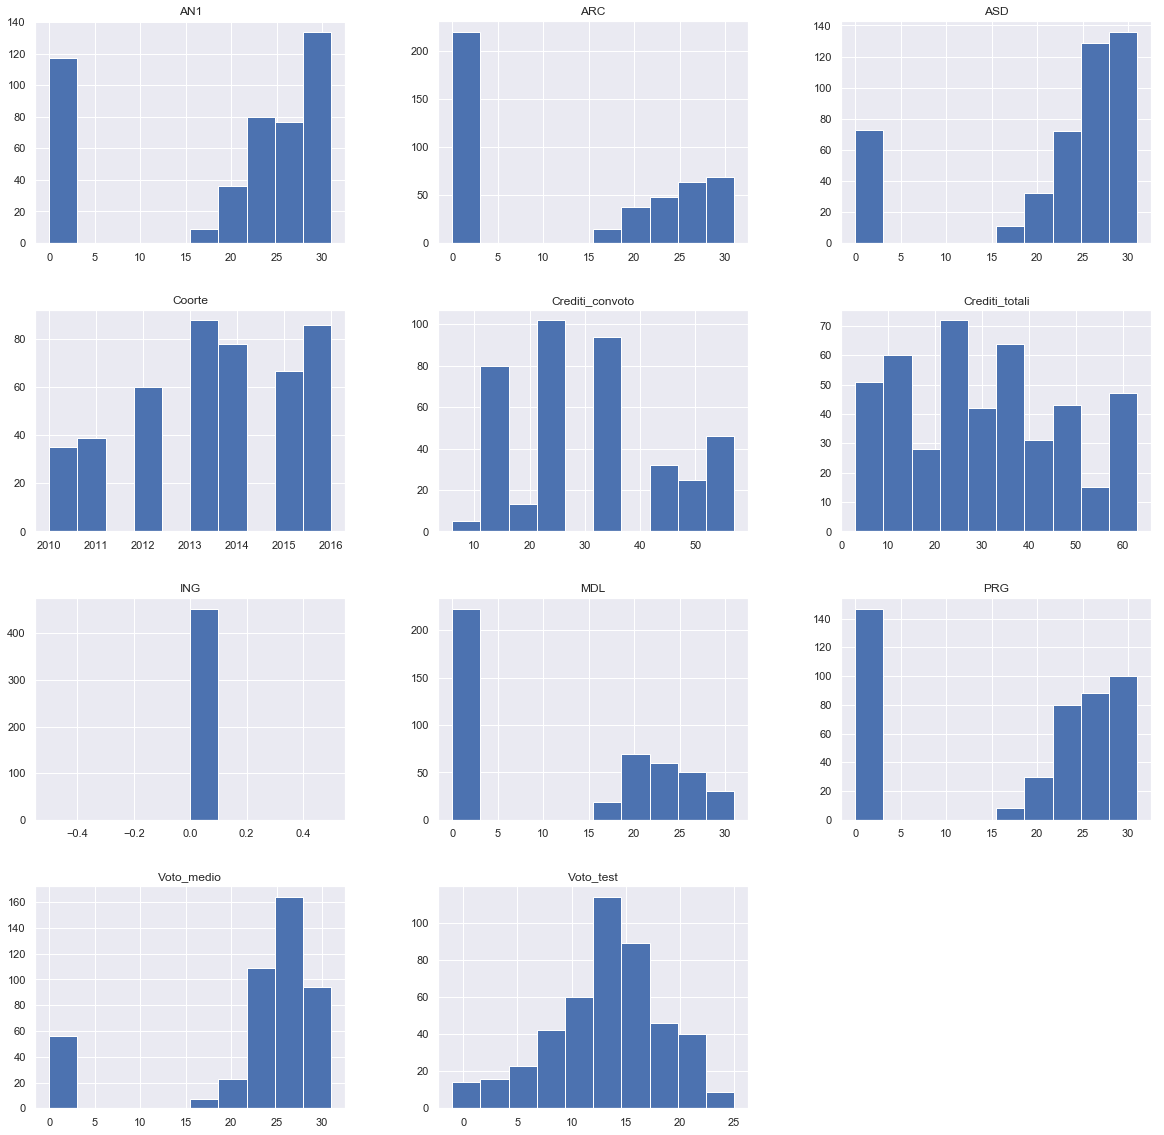

In [4]:
dataset.hist(figsize=(20,20))
plt.savefig("./histogramma.png")

>Per ridurre ulteriormente la dimensione di analisi abbiamo eseguito una **matrice di correlazione secondo Pearson** per capire se vi è la presenza di variabili altamente correlate, è abbiamo osservato che le colonne **Crediti_totali** e **Crediti_convoto** sono altamente correllate perchè crediti_totali è combinazione lineare della colonna crediti_convoto, più semplicemente è un sovrainsieme di **crediti_convoto**, per tanto si può tenere una tra le due colonne per l'analisi.
Osserviamo attraverso la funzione isna().sum() che **crediti_totali** non ha valori **NaN** a differenza  di **crediti_convoto**, perciò preferiamo condurre l'analisi con questa colonna.

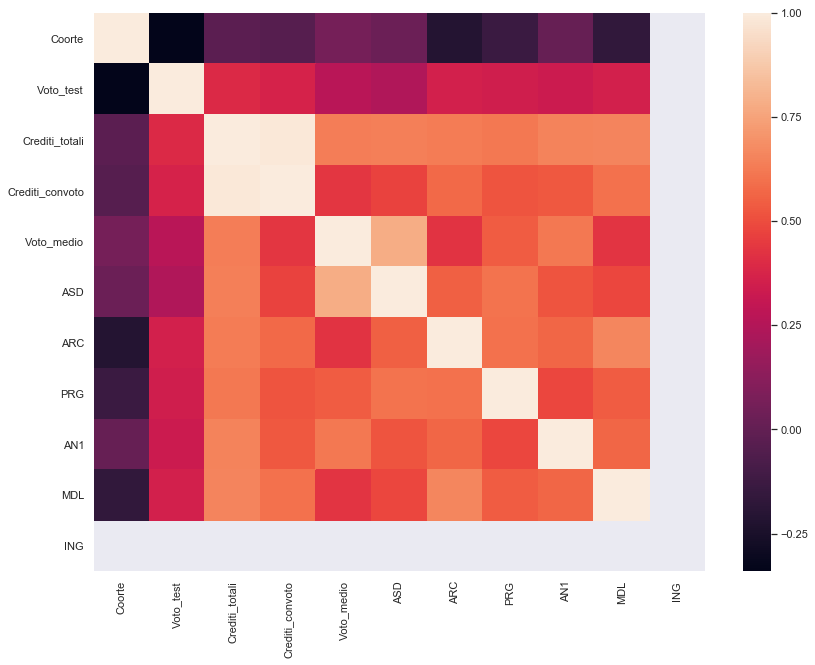

In [5]:
matrixCorr =sns.heatmap(dataset.corr())
figMatrixCorr = matrixCorr.get_figure()
figMatrixCorr.savefig('./matrixCorr.png')

In [6]:
dataset.isna().sum()

Coorte                 0
Genere                 0
Voto_test              0
Crediti_totali         0
Crediti_convoto       56
Voto_medio             0
Scuola_provenienza    12
ASD                    0
data_ASD               0
ARC                    0
data_ARC               0
PRG                    0
data_PRG               0
AN1                    0
data_AN1               0
MDL                    0
data_MDL               0
ING                    0
data_ING               0
dtype: int64

In [7]:
dataset = dataset.drop(labels=["Crediti_convoto","data_ASD", "data_ARC","data_PRG","data_AN1", "data_MDL","ING"], axis = 1)

>Dall'istogramma le colonne che rappresentano i voti dei corsi sostenuti dagli studenti, abbiamo osservato che i valori sono compresi in un intervallo di valori tra 18 e 31, più il valore 0 che indica che lo studente non ha sostenuto l'esame.
Poiche non ci sono dei voti anomali, abbiamo scritto una procedura che estrare un sotto dataset composto dalle colonne degli esami, dove se il voto è maggiore di 0 sostituisce il valore con SI altrimenti con NO, la procedura prende in ingresso anche data_ING dove si esegue la medesima operazione.
Osserviamo che la colonna ING contiene i valori: '0' e '0000/00/00'.
Abbiamo interpretato il valore '0' come la data nulla, mentre la data '0000/00/00' doveva essere la data di verbalizzazione  ma per qualche motivo è stata corrotta.
Abbiamo salvato il sotto dataset con il nome **ds_apriori.csv** per poter condurre l'analisi associativa con con Weka, i risultati di questa analisi si trovano nella relazione. 

In [8]:
def frameApriori(ds,data_ING):
    exam_list = ds.columns
    ds_copy = ds.copy()
    shape = ds.shape
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            if(ds_copy.iloc[i,j]>0):
                ds_copy.iloc[i,j] ="yes"
            else:
                ds_copy.iloc[i,j] ="no"
                
    ing = []
    for i in range(0,len(data_ING)):
        if(data_ING[i]=="0"):
            ing.append("no")
        else:
            ing.append("yes")
    ds_copy["ING"] = ing
    
    return ds_copy
                
    

In [9]:
exams_list = ["ASD", "ARC", "PRG", "AN1", "MDL"]
datasetVoti = dataset[exams_list]
data_ing =  dataset.data_ING
datasetApriori = frameApriori(datasetVoti,data_ing)
datasetApriori.to_csv(path_or_buf="C:/Users/matte/dmo_progetto/data/interim/ds_apriori.csv", index=False) # dataset per l'apriori
dataset = dataset.drop(labels=["data_ING"], axis = 1)

> A questo punto ci occupiamo delle variabili categoriche in particolare di **Genere** e **Scuola_provenienza**, dalla funzione isna().sum() rileviamo che solo Scuola_provenienza ha dei valori NaN, pertanto usiamo la funzione describe() per scoprire la moda della colonna, che è rappresentata dal valore **IT** e usando la funzione fillna(value="IT") sostituiamo i valori NaN con IT.
Il motivo del perchè abbiamo usato la moda è semplice, media e la mediana sono indici di posizione per valori quantitativi, tuttavia la mediana si può usare su valori categorici ma solo se è presente una relazione d'ordine totale sui valori, pertanto per esclusione rimane la moda.

In [10]:
dataset.isna().sum() 

Coorte                 0
Genere                 0
Voto_test              0
Crediti_totali         0
Voto_medio             0
Scuola_provenienza    12
ASD                    0
ARC                    0
PRG                    0
AN1                    0
MDL                    0
dtype: int64

In [11]:
dataset.Scuola_provenienza.describe()

count     441
unique     10
top        IT
freq      179
Name: Scuola_provenienza, dtype: object

In [12]:
dataset.Scuola_provenienza = dataset.Scuola_provenienza.fillna(value="IT")

> Gli algoritmi di machine learning in particolare quelli non supervionati come il **K-means** lavorano principalmente solo con dati numerici, per tanto per poter utilizzare durante l'analisi dobbiamo codificare apportunamente le variabili.
Usando l' attributo **cat.codes** per la variabile genere abbiamo scelto una codifica binari:
* 1 per i maschi
* 0 per le femmine

>Per la scuola di provenienza la codifica è la seguente:
* 4 per IT
* 7 per LS
* 8 per TC
* 9 per XX
* 0 per AL
* 5 per LC
* 2 per IP
* 6 per LL
* 1 per IA
* 3 per IPC

In [13]:
dataset["Genere"] = dataset["Genere"].astype('category')
dataset["Genere"] = dataset["Genere"].cat.codes
dataset["Scuola_provenienza"] = dataset["Scuola_provenienza"].astype('category')
dataset["Scuola_provenienza"] = dataset["Scuola_provenienza"].cat.codes

>Nella [descrizione](https://e-l.unifi.it/pluginfile.php/750445/mod_resource/content/3/README%202018-19.dat) del dataset è riportato che gli studenti che appartengono alla Coorte 2016 sono stati valutati con un test d'ingresso diverso da quelli degli anni precedenti.
Per riconcigliare i voti al test d'ingresso degli studenti abbiamo eseguito la seguente strategia:
* si dividono gli studenti in 2 tabelle, in una quelli con con la coorte del 2016 e i restanti nell'altra.
* per ciascuna tabella si standardizza la colonna Voto_test con la propria media e deviazione standard con un oggetto di tipo StandardScaler
* per ottenere la tabella originale si esegue una unione

In [14]:
scaler = preprocessing.StandardScaler()
datasetCoorteFino2015 = dataset[dataset['Coorte']<=2015]
datasetCoorte2016 = dataset[dataset['Coorte']>2015]
columns_list = dataset.columns

In [15]:
Voto_test2016 = scaler.fit_transform(pd.DataFrame(data=datasetCoorte2016["Voto_test"], columns =["Voto_test"]))
Voto_testFino2015 = scaler.fit_transform(pd.DataFrame(data=datasetCoorteFino2015["Voto_test"], columns =["Voto_test"]))

In [16]:
datasetCoorteFino2015["Voto_test"] = Voto_testFino2015
datasetCoorte2016["Voto_test"] = Voto_test2016

In [17]:
frames = [datasetCoorteFino2015, datasetCoorte2016]
datasetUnione = pd.concat(frames)

In [18]:
datasetUnione.to_csv(path_or_buf="C:/Users/matte/dmo_progetto/data/interim/datasetUnione.csv", index=False)

> datasetUnione è il risultato finale del pre processing.

In [21]:
#datasetStandar = scaler.fit_transform(datasetUnione)
#datasetStandar = pd.DataFrame(datasetStandar , columns=columns_list)
#datasetClustering = datasetStandar.copy()
#datasetClustering.to_csv(path_or_buf="C:/Users/matte/dmo_progetto/data/interim/datasetClustering.csv", index=False)
datasetUnione.head(10)

,Coorte,Genere,Voto_test,Crediti_totali,Voto_medio,Scuola_provenienza,ASD,ARC,PRG,AN1,MDL
0,2010,1,0.800405,3,0.0,8,0,0,0,0,0
1,2010,1,-0.359740,3,0.0,7,0,0,0,0,0
2,2010,1,0.104318,3,0.0,4,0,0,0,0,0
3,2010,1,0.568376,9,20.0,7,25,23,26,24,20
4,2010,1,-3.376116,12,0.0,4,0,0,0,0,0
5,2010,0,-0.591769,12,0.0,7,0,0,0,0,0
6,2010,1,-0.591769,12,18.0,4,18,20,18,25,0
7,2010,1,-0.359740,12,22.0,8,22,24,21,19,24
8,2010,1,-1.055827,12,24.0,2,24,0,0,20,18
9,2010,1,0.104318,12,26.0,8,26,0,25,0,0
